# RecentCandles Dashboard
 
Contract info can be found here: https://pennies.interactivebrokers.com/cstools/contract_info/v3.10/index.php 

## 3CR Indicator
The recent candlesticks include "3CR" reversal indicators

<img src="./images/3cr-1.png"  width="600" height="300">
<img src="./images/3cr-2.png"  width="600" height="300">

## 2B Reversal
<img src="./images/2breversal.jpg"  width="600" height="300">



## Connect to IB

In [1]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
from ibapi.contract import Contract

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates

import talib

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

import threading
import time

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

    def tickPrice(self, reqId, tickType, price, attrib):
        if tickType == 2 and reqId == 1:
            print(tickType, ': The current ask price is: ', price)
    
    def historicalData(self, reqId, bar):        
        collectData(reqId, bar)

def run_loop():
    ib.run()

ib = IBapi()
ib.connect('host.docker.internal', 7496, 667)

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1)


ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:uscrypto
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:afarm
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds.nj
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefeu


## Setup data for Dashboard


In [2]:
class ContractWrapper:

    def __init__(self, contract, contractName = None):
        self.contract = contract
        self.data = dict() # data keyed by ReqId
        if contractName is not None:
            self.contractName = contractName
        else:
            self.contractName = (contract.symbol, contract.symbol+'_'+contract.currency)[contract.exchange == 'IDEALPRO']

class Contracts:

    def __init__(self):
        self.contracts = list()
        
    def info(self):
        return f"list of contracts: {self.contracts} "

    def add(self, contractWrapper: ContractWrapper):
        self.contracts.append(contractWrapper)

# Define Contracts
contractsList = Contracts()
def addContract(symbol, secType, exchange, currency, contractMonth = None, contractName = None):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    if contractMonth is not None:
        contract.lastTradeDateOrContractMonth = contractMonth
    wrapper = ContractWrapper(contract, contractName)
    contractsList.add(wrapper)

def determine_date_format(date_str):
    #20230407
    formats = ['%Y%m%d', '%Y%m%d %H:%M:%S']
    for fmt in formats:
        try:
            datetime.strptime(date_str, fmt)
            return fmt
        except ValueError:
            pass
    return None

# Define a callback for IB Historical data
def collectData(reqId, bar): 
    for contractItem in contractsList.contracts:
        if reqId in contractItem.data.keys():
            dateFormat = determine_date_format(bar.date)
            #print(f'Date format {dateFormat}')
            seconds = None
            if dateFormat:
                date = datetime.strptime(bar.date, dateFormat)
                seconds = (date - datetime(1970, 1, 1)).total_seconds()
            else:
                seconds = bar.date
            thisCandle = [seconds, bar.open, bar.high, bar.low, bar.close]
            contractItem.data[reqId].append(thisCandle)               

# Find reversals for a specific candleSize dataFrame, e.g. EURUSD 4H candles for  
def find_reversal_points(df): 
    reversal_points = []
    down_reversal_points = []
    # Loop through the DataFrame rows
    minus1Candle = None
    minus1CandleIndex = None
    minus2Candle = None
    minus2CandleIndex = None
    #print(f"No of rows in dataFrame: {len(df)}")
    for index, thisCandle in df.iterrows():
        
        # Check for 2B reversal to the upside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] < minus2Candle['Low'] \
            and minus1Candle['High'] < minus2Candle['High'] \
            and thisCandle['Close'] > minus2Candle['High']:
            #print(f"Register 2b reversal: close {thisCandle['Close']} > -2 high {minus2Candle['High']}")
            reversal_points.append(thisCandle['Low'])
        else:
            reversal_points.append(np.nan)
        
        # Check for 2B reversal to the downside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] > minus2Candle['Low'] \
            and minus1Candle['High'] > minus2Candle['High'] \
            and thisCandle['Close'] < minus2Candle['Low']:
            down_reversal_points.append(thisCandle['High'])
        else:
            down_reversal_points.append(np.nan)
                
        # Update the previous candles variables for the next iteration
        minus2Candle = minus1Candle
        minus2CandleIndex = minus1CandleIndex

        minus1Candle = thisCandle
        minus1CandleIndex = index

    return reversal_points, down_reversal_points


# Sanitise data ndarray to DataFrame
def to_dataframe(data):
    if not data:
        return None
    
    df = pd.DataFrame(data, columns=['DateTime', 'Open', 'High', 'Low', 'Close'])
    df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s', infer_datetime_format=True)
    df = df.set_index('DateTime')
    
    df['ema10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['ema30'] = df['Close'].ewm(span=30, adjust=False).mean()

    return df

# Sanitise data ndarray to DataFrame, return only last 6 candles
def to_dataframe_last6candles(data):
    if not data:
        return None
    df = to_dataframe(data)
    df = df.tail(6)
    return df
"""
def add_2b_reversal_date(df):
    # Define your rules to identify 2B reversal
    if len(candles) < 3:
        return False

    # Check for a bullish 2B reversal
    if candles[-3]['trend'] == 'down' and \
       candles[-2]['low'] < candles[-3]['low'] and \
       candles[-1]['high'] > candles[-2]['high']:
        return True

    # Check for a bearish 2B reversal
    if candles[-3]['trend'] == 'up' and \
       candles[-2]['high'] > candles[-3]['high'] and \
       candles[-1]['low'] < candles[-2]['low']:
        return True

    return False
"""
# Initialise Contracts for the Dashboard    
addContract('EUR', 'CASH', 'IDEALPRO', 'USD', contractName='EUR.USD')
addContract('EUR', 'CASH', 'IDEALPRO', 'ZAR', contractName='EUR.ZAR')
addContract('USD', 'CASH', 'IDEALPRO', 'JPY', contractName='USD.JPY')
addContract('ES', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='ES Futures')
addContract('MNQ', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='E-Mini NQ 100')
addContract('YM', 'FUT', 'CBOT', 'USD', contractMonth='20230616', contractName='Dow Jones (YM)')
#addContract('XLE', 'CONTFUT', 'ONE', 'USD')
addContract('TLT', 'STK', 'SMART', 'USD')
addContract('BRR', 'FUT', 'CME', 'USD', contractMonth='20230526', contractName='BTC Futures')
addContract('XAUUSD', 'CMDTY', 'SMART', 'USD', contractName='Gold')
addContract('XAGUSD', 'CMDTY', 'SMART', 'USD', contractName='Silver')
#addContract('BTC', 'CRYPTO', 'PAXOS', 'USD')
#print(contractsList.contracts)

## Request IB historical data

In [3]:
timeSpan = '6 W'
candleSizes = ['1 week','1 day','4 hours','1 hour']
#candleSizes = ['1 hour']

rId = 0
for contract in contractsList.contracts:
    print(f"Requesting historical data for {contract.contract.symbol}_{contract.contract.currency} ...")
    for candleSize in candleSizes:
        rId = rId + 1
        print(f"    ReqID {rId} - timeSpan:'{timeSpan}' candleSize:'{candleSize}'")
        contract.data[rId] = list()
        ib.reqHistoricalData(rId, contract.contract, '', timeSpan, candleSize, 'MIDPOINT', 0, 2, False, [])
        #print(f"  ReqID {rId} Done.")
        time.sleep(0.1)
    print(f"Done for {contract.contract.symbol}_{contract.contract.currency} ...")
    print(f"------------------------------------------------------------------------------------------")

#wait for all data to come in
time.sleep(3)

Requesting historical data for EUR_USD ...
    ReqID 1 - timeSpan:'6 W' candleSize:'1 week'
    ReqID 2 - timeSpan:'6 W' candleSize:'1 day'
    ReqID 3 - timeSpan:'6 W' candleSize:'4 hours'
    ReqID 4 - timeSpan:'6 W' candleSize:'1 hour'
Done for EUR_USD ...
------------------------------------------------------------------------------------------
Requesting historical data for EUR_ZAR ...
    ReqID 5 - timeSpan:'6 W' candleSize:'1 week'
    ReqID 6 - timeSpan:'6 W' candleSize:'1 day'
    ReqID 7 - timeSpan:'6 W' candleSize:'4 hours'
    ReqID 8 - timeSpan:'6 W' candleSize:'1 hour'
Done for EUR_ZAR ...
------------------------------------------------------------------------------------------
Requesting historical data for USD_JPY ...
    ReqID 9 - timeSpan:'6 W' candleSize:'1 week'
    ReqID 10 - timeSpan:'6 W' candleSize:'1 day'
    ReqID 11 - timeSpan:'6 W' candleSize:'4 hours'
    ReqID 12 - timeSpan:'6 W' candleSize:'1 hour'
Done for USD_JPY ...
-----------------------------------

## Plot 

## Plot in Grid

Ploting figure of 10 rows, 4 columns
EUR.USD [W] - TF: W
EUR.USD [D] - TF: D
EUR.USD [4H] - TF: 4H
EUR.USD [1H] - TF: 1H
EUR.ZAR [W] - TF: W
EUR.ZAR [D] - TF: D
EUR.ZAR [4H] - TF: 4H
EUR.ZAR [1H] - TF: 1H
USD.JPY [W] - TF: W
USD.JPY [D] - TF: D
USD.JPY [4H] - TF: 4H
USD.JPY [1H] - TF: 1H
ES Futures [W] - TF: W
ES Futures [D] - TF: D
ES Futures [4H] - TF: 4H
ES Futures [1H] - TF: 1H
E-Mini NQ 100 [W] - TF: W
E-Mini NQ 100 [D] - TF: D
E-Mini NQ 100 [4H] - TF: 4H
E-Mini NQ 100 [1H] - TF: 1H
Dow Jones (YM) [W] - TF: W
Dow Jones (YM) [D] - TF: D
Dow Jones (YM) [4H] - TF: 4H
Dow Jones (YM) [1H] - TF: 1H
TLT [W] - TF: W
TLT [D] - TF: D
TLT [4H] - TF: 4H
BTC Futures [W] - TF: W
BTC Futures [D] - TF: D
Gold [W] - TF: W
Gold [D] - TF: D
Gold [4H] - TF: 4H
Gold [1H] - TF: 1H
Silver [W] - TF: W
Silver [D] - TF: D
Silver [4H] - TF: 4H
Executed at 2023-05-21 10:46:07.595192+02:00


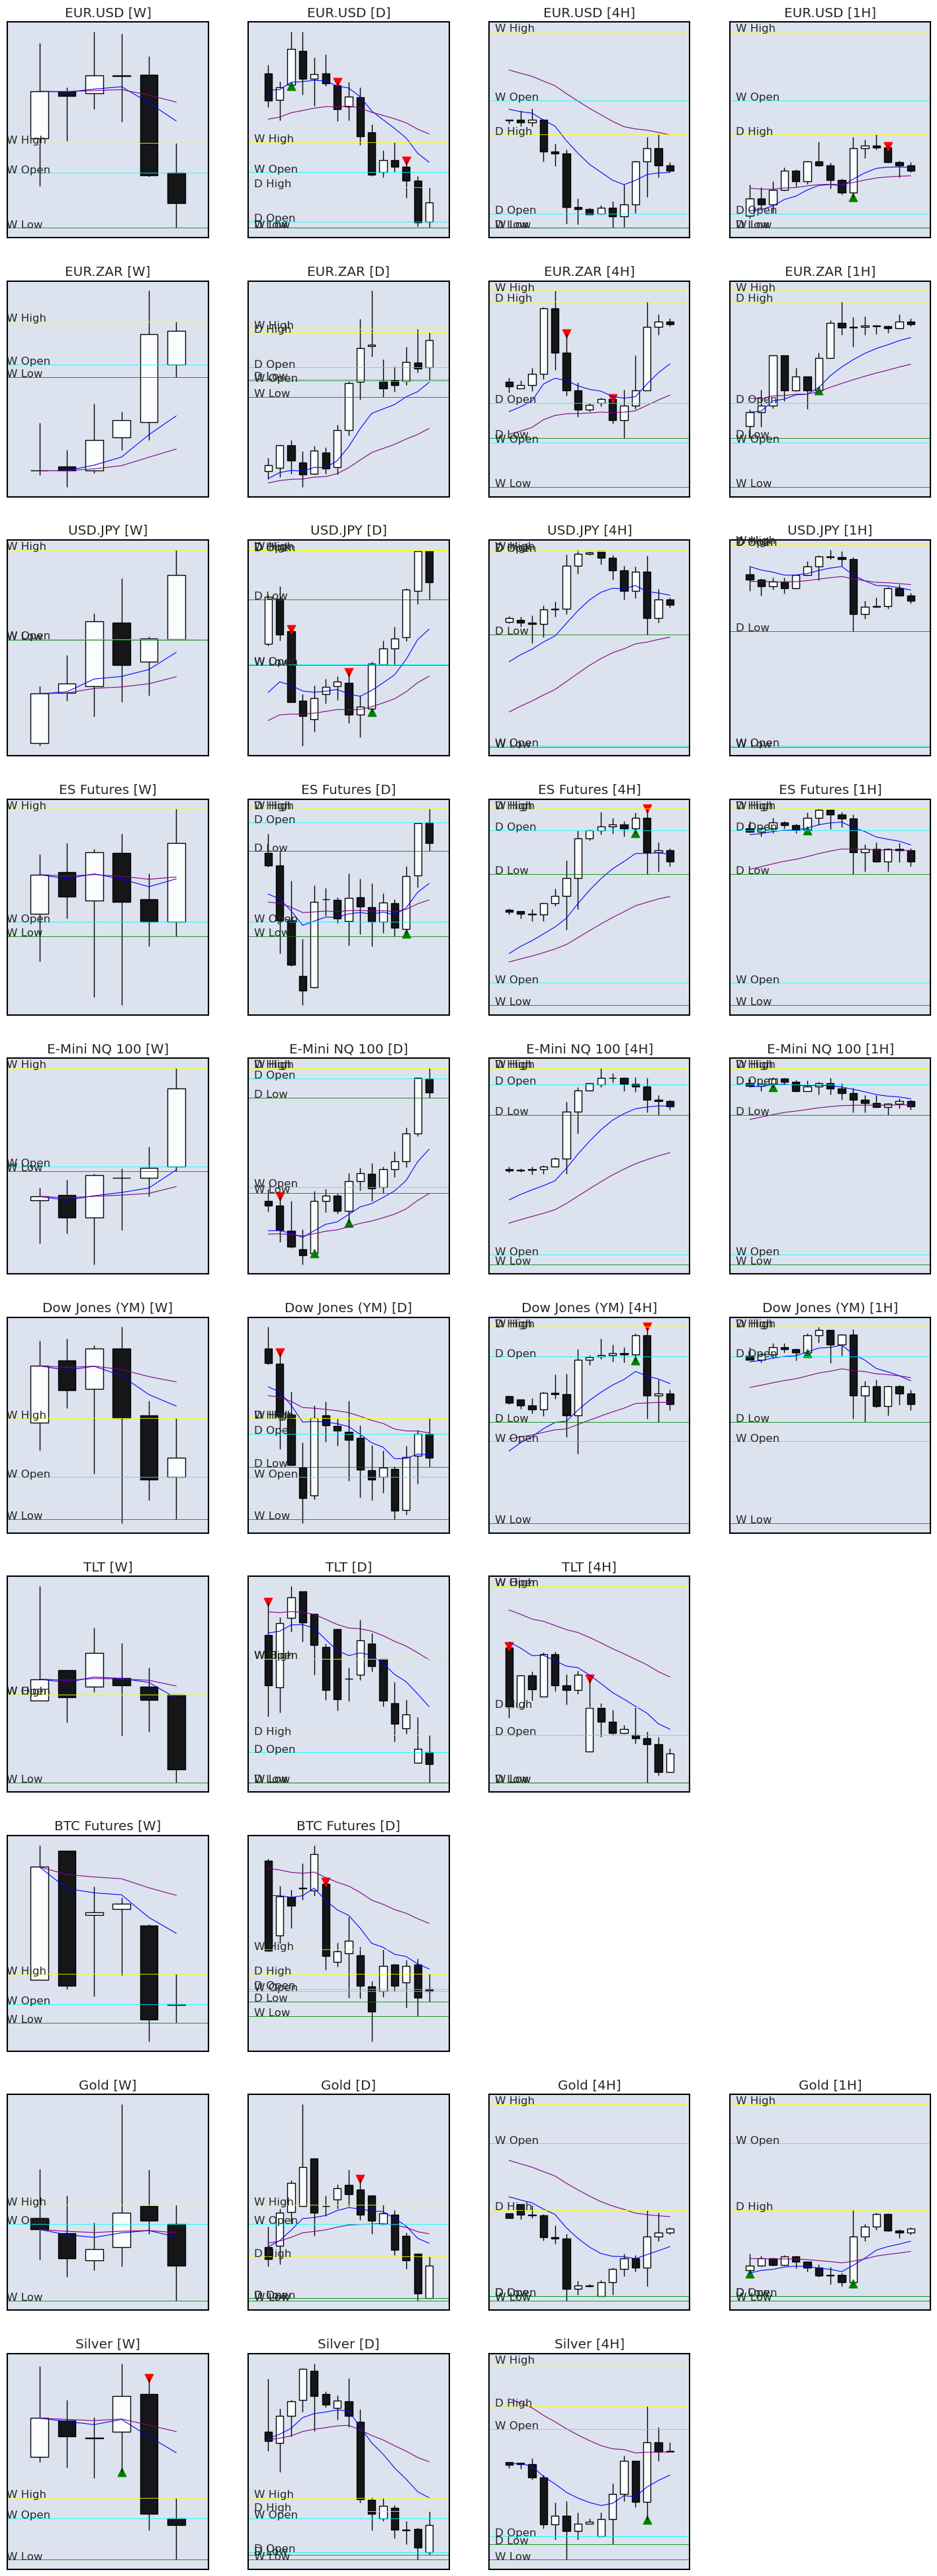

In [4]:
candleSizes = ['W','D','4H','1H']
rows = len(contractsList.contracts)
columns = len(candleSizes)
rowHeight = 5
figWidth = 18
figHeight = rowHeight * rows
noOfCandles = 15
print(f'Ploting figure of {rows} rows, {columns} columns')
fig = mpf.figure(figsize=(figWidth,figHeight))

def get_title(reqId, columns, contractName):
    diff = reqId%columns
    title = contractName
    match diff:
        case 1: # Weekly
            title = f"{c.contractName} [{candleSizes[0]}]"
        case 2: # Daily
            title = f"{c.contractName} [{candleSizes[1]}]"
        case 3: # H4
            title = f"{c.contractName} [{candleSizes[2]}]"
        case 0: # H1
            title = f"{c.contractName} [{candleSizes[3]}]"    
    return title

def get_timeframe(reqId, columns, contractName):
    diff = reqId%columns
    match diff:
        case 1: # Weekly
            return candleSizes[0]
        case 2: # Daily
            return candleSizes[1]
        case 3: # H4
            return candleSizes[2]
        case 0: # H1
            return candleSizes[3]
    return title

# For each contract
for c in contractsList.contracts:    
    # For each requested candleSize data array. key=reqId, value=contractNDArray
    
    weekly_open_price = None
    weekly_high_price = None
    weekly_low_price = None
    daily_open_price = None
    daily_high_price = None
    daily_low_price = None
    
    for reqId, contractDataArray in c.data.items():    
        if contractDataArray:
            title = get_title(reqId, columns, c.contractName)
            tf = get_timeframe(reqId, columns, c.contractName)
            print(f'{title} - TF: {tf}')
            contractPriceDataDF = to_dataframe(contractDataArray)
            
            # 3CR Reversals
            reversalPoints, downReversalPoints = find_reversal_points(contractPriceDataDF)
            negNoOfCandles = -noOfCandles
            reversalPoints = reversalPoints[negNoOfCandles:]
            downReversalPoints = downReversalPoints[negNoOfCandles:]
            noReversals = all(np.isnan(item) for item in reversalPoints)
            noDownReversals = all(np.isnan(item) for item in downReversalPoints)
            # end - 3CR Reversals

            contractPriceDataDF = contractPriceDataDF.tail(noOfCandles)

            ax1 = fig.add_subplot(rows, columns, reqId)
            ax1.axes.xaxis.set_visible(False)
            ax1.axes.yaxis.set_visible(False)
            #hlines=dict(hlines=(weekly_open_price), colors=['g'], linestyle='dotted', linewidths=(1,1) )
            #vlines=dict(vlines=(weekly_open_date), linewidths=0.5, colors=('r'))

            aps=[]
            if not noDownReversals:
                aps.append(mpf.make_addplot(downReversalPoints, ax=ax1, type='scatter', marker='v', markersize=80, color='red'))
            if not noReversals:
                aps.append(mpf.make_addplot(reversalPoints, ax=ax1, type='scatter', marker='^', markersize=80, color='green'))

            aps.append(mpf.make_addplot(contractPriceDataDF['ema10'], ax=ax1, color='blue', width=0.8))
            aps.append(mpf.make_addplot(contractPriceDataDF['ema30'], ax=ax1, color='purple', width=0.8))

            mpf.plot(contractPriceDataDF, ax=ax1, addplot=aps, type='candle', axtitle=title)
            #mpf.plot(contractPriceDataDF, ax=ax1, addplot=aps, vlines=vlines, type='candle', axtitle=title)
                   
            # Horizontal lines for Weekly & Daily prices
            if tf == 'W':
                weekly_open_price = contractPriceDataDF['Open'].iloc[-1]
                weekly_high_price = contractPriceDataDF['High'].iloc[-1]
                weekly_low_price = contractPriceDataDF['Low'].iloc[-1]   
            if tf == 'D':
                daily_open_price = contractPriceDataDF['Open'].iloc[-1]
                daily_high_price = contractPriceDataDF['High'].iloc[-1]
                daily_low_price = contractPriceDataDF['Low'].iloc[-1]
                max_daily_high = contractPriceDataDF['High'].max()
            
            ax1.axhline(weekly_open_price, color='cyan', linewidth=0.6)
            ax1.annotate('W Open', xy=(0,weekly_open_price), xytext=(-1.2,weekly_open_price))
            ax1.axhline(weekly_high_price, color='yellow', linewidth=0.6)
            ax1.annotate('W High', xy=(0,weekly_high_price), xytext=(-1.2,weekly_high_price))
            ax1.axhline(weekly_low_price, color='green', linewidth=0.6)
            ax1.annotate('W Low', xy=(0,weekly_low_price), xytext=(-1.2,weekly_low_price))
            # end - Horizontal lines
            
            # Weekly open / high /low
            if daily_open_price:
                ax1.axhline(daily_open_price, color='cyan', linewidth=0.6)
                ax1.annotate('D Open', xy=(0,daily_open_price), xytext=(-1.2,daily_open_price))
                ax1.axhline(daily_high_price, color='yellow', linewidth=0.6)
                ax1.annotate('D High', xy=(0,daily_high_price), xytext=(-1.2,daily_high_price))
                ax1.axhline(daily_low_price, color='green', linewidth=0.6)
                ax1.annotate('D Low', xy=(0,daily_low_price), xytext=(-1.2,daily_low_price))
                
            

print(f"Executed at {datetime.now(ZoneInfo('Europe/Amsterdam'))}")


# Disconnect from IB

In [5]:
ib.disconnect()